# Validate Turbo and Convolutional Codes

Test convolutional and Turbo codes against multiple baselines and sweep over cosntraint length, to verify that correct polynomials are taken.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time # for throughput measurements

In [2]:
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 1 # Number of the GPU to be used
    try:
        #tf.config.set_visible_devices([], 'GPU')
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

Number of GPUs available : 2
Only GPU number 1 used.


In [3]:
import sys
sys.path.append('../')
import sionna # needs to be installed
%reload_ext autoreload
%autoreload 2
import importlib
importlib.reload(sionna)

# Load the required Sionna components
from sionna.mapping import Constellation, Mapper, Demapper
from sionna.fec.polar import PolarEncoder, Polar5GEncoder, PolarSCLDecoder, Polar5GDecoder, PolarSCDecoder
from sionna.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.fec.polar.utils import generate_5g_ranking, generate_rm_code
from sionna.fec.conv import ConvEncoder, ViterbiDecoder, BCJRDecoder
from sionna.fec.turbo import TurboEncoder, TurboDecoder
from sionna.utils import BinarySource, ebnodb2no
from sionna.utils.metrics import  count_block_errors
from sionna.channel import AWGN
from sionna.utils.plotting import PlotBER
from sionna.fec.utils import GaussianPriorSource, llr2mi

In [4]:
class System_Model(tf.keras.Model):
    """System model for channel coding BER simulations.
    
    This model allows to simulate BERs over an AWGN channel with
    QAM modulation. Arbitrary FEC encoder/decoder layers can be used to 
    initialize the model.
    
    Parameters
    ----------
        k: int
            number of information bits per codeword.
        
        n: int 
            codeword length.
        
        num_bits_per_symbol: int
            number of bits per QAM symbol.
            
        encoder: Keras layer
            A Keras layer that encodes information bit tensors.
            
        decoder: Keras layer
            A Keras layer that decodes llr tensors.
            
        demapping_method: str
            A string denoting the demapping method. Can be either "app" or "maxlog".
            
        sim_esno: bool  
            A boolean defaults to False. If true, no rate-adjustment is done for the SNR calculation.
            
    Input
    -----
        batch_size: int or tf.int
            The batch_size used for the simulation.
        
        ebno_db: float or tf.float
            A float defining the simulation SNR.
            
    Output
    ------
        (u, u_hat):
            Tuple:
        
        u: tf.float32
            A tensor of shape `[batch_size, k] of 0s and 1s containing the transmitted information bits.           

        u_hat: tf.float32
            A tensor of shape `[batch_size, k] of 0s and 1s containing the estimated information bits.           
    """
    def __init__(self,
                 k,
                 n,
                 num_bits_per_symbol,                 
                 encoder,
                 decoder,
                 demapping_method="app",
                 sim_esno=False):

        super().__init__()
        
        # store values internally
        self.k = k
        self.n = n
        self.sim_esno = sim_esno # disable rate-adjustment for SNR calc
        
        # number of bit per QAM symbol
        self.num_bits_per_symbol = num_bits_per_symbol

        # init components
        self.source = BinarySource()
       
        # initialize mapper and demapper for constellation object
        self.constellation = Constellation("qam",
                                num_bits_per_symbol=self.num_bits_per_symbol)
        self.mapper = Mapper(constellation=self.constellation)
        self.demapper = Demapper(demapping_method,
                                 constellation=self.constellation)
        
        # the channel can be replaced by more sophisticated models
        self.channel = AWGN()

        # FEC encoder / decoder
        self.encoder = encoder
        self.decoder = decoder

    @tf.function(jit_compile=True) # enable graph mode for increased throughputs
    def call(self, batch_size, ebno_db):
        
        u = self.source([batch_size, self.k]) # generate random data
        c = self.encoder(u) # explicitly encode

        # calculate noise variance
        if self.sim_esno:
            no = ebnodb2no(ebno_db,
                       num_bits_per_symbol=1,
                       coderate=1)
        else: 
            no = ebnodb2no(ebno_db,
                           num_bits_per_symbol=self.num_bits_per_symbol,
                           coderate=self.k/self.n)            
        
        x = self.mapper(c) # map c to symbols x

        y = self.channel([x, no]) # transmit over AWGN channel

        llr_ch = self.demapper([y, no]) # demap y to LLRs

        u_hat = self.decoder(llr_ch) # run FEC decoder (incl. rate-recovery)
        return u, u_hat

## Test against APP

In [22]:
# code parameters
k = 512 # number of information bits per codeword
n = 1548 # desired codeword length
num_bits_per_symbol = 2 # QPSK
ebno_db = np.arange(0, 2.6, 0.2) # sim SNR range 

codes_under_test = []
#Turbo. codes
enc = TurboEncoder(rate=1/3, constraint_length=4, terminate=True)
dec = TurboDecoder(encoder=enc, num_iter=3)
name = "Turbo - iter 3"
codes_under_test.append([enc, dec, name])

enc = TurboEncoder(rate=1/3, constraint_length=4, terminate=True)
dec = TurboDecoder(encoder=enc, num_iter=6)
name = "Turbo - iter 6"
codes_under_test.append([enc, dec, name])

ber_plot1 = PlotBER(f"BER/BLER Performance (k={k}, n={n})")

# run ber simulations for each code we have added to the list
for code in codes_under_test:
    print("\n Running: " + code[2])
    
    # generate a new model with the given encoder/decoder
    model = System_Model(k=k,
                         n=n,
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=code[0],
                         decoder=code[1],
                         sim_esno=False)
    
    # the first argument must be a callable (function) that yields u and u_hat for batch_size and ebno
    ber_plot1.simulate(model, # the function have defined previously
                     ebno_dbs=ebno_db, # SNR to simulate
                     legend=code[2], # legend string for plotting
                     max_mc_iter=100, # run 100 Monte Carlo runs per SNR point
                     num_target_bit_errors=1000, # continue with next SNR point after 1000 bit errors
                     batch_size=10000, # batch-size per Monte Carlo run
                     soft_estimates=False, # the model returns hard-estimates
                     early_stop=True, # stop simulation if no error has been detected at current SNR point
                     show_fig=False, # we show the figure after all results are simulated
                     add_bler=True, # in case BLER is also interresting
                     forward_keyboard_interrupt=False); # should be True in a loop

# Matlab APP
# https://de.mathworks.com/help/comm/ug/parallel-concatenated-convolutional-coding-turbo-codes.html

snr = [0, 0.5, 1, 1.5, 2, 2.5]
ber = [9e-2, 3e-2, 3e-3, 9e-5, 2e-6, 8e-8]
ber_plot1.add(snr, ber, is_bler=False,legend="APP iter 3")


snr = [0, 0.5, 1, 1.5, 1.75]
ber = [8e-2, 1.5e-2, 5e-4, 1.5e-5, 1.5e-6]
ber_plot1.add(snr, ber, is_bler=False,legend="APP iter 6")



 Running: Turbo - iter 3
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 9.1508e-02 | 9.6380e-01 |      468519 |     5120000 |         9638 |       10000 |         9.4 |reached target bit errors
      0.2 | 6.3263e-02 | 8.8140e-01 |      323905 |     5120000 |         8814 |       10000 |         0.2 |reached target bit errors
      0.4 | 3.9799e-02 | 7.3070e-01 |      203770 |     5120000 |         7307 |       10000 |         0.2 |reached target bit errors
      0.6 | 2.0054e-02 | 5.0900e-01 |      102676 |     5120000 |         5090 |       10000 |         0.2 |reached target bit errors
      0.8 | 8.5195e-03 | 2.8990e-01 |       43620 |     5120000 |         2899 |       10000 |         0.2 |reached target bit errors
      1.0 | 3.2289e-03 | 1.3890e-01 |       16532

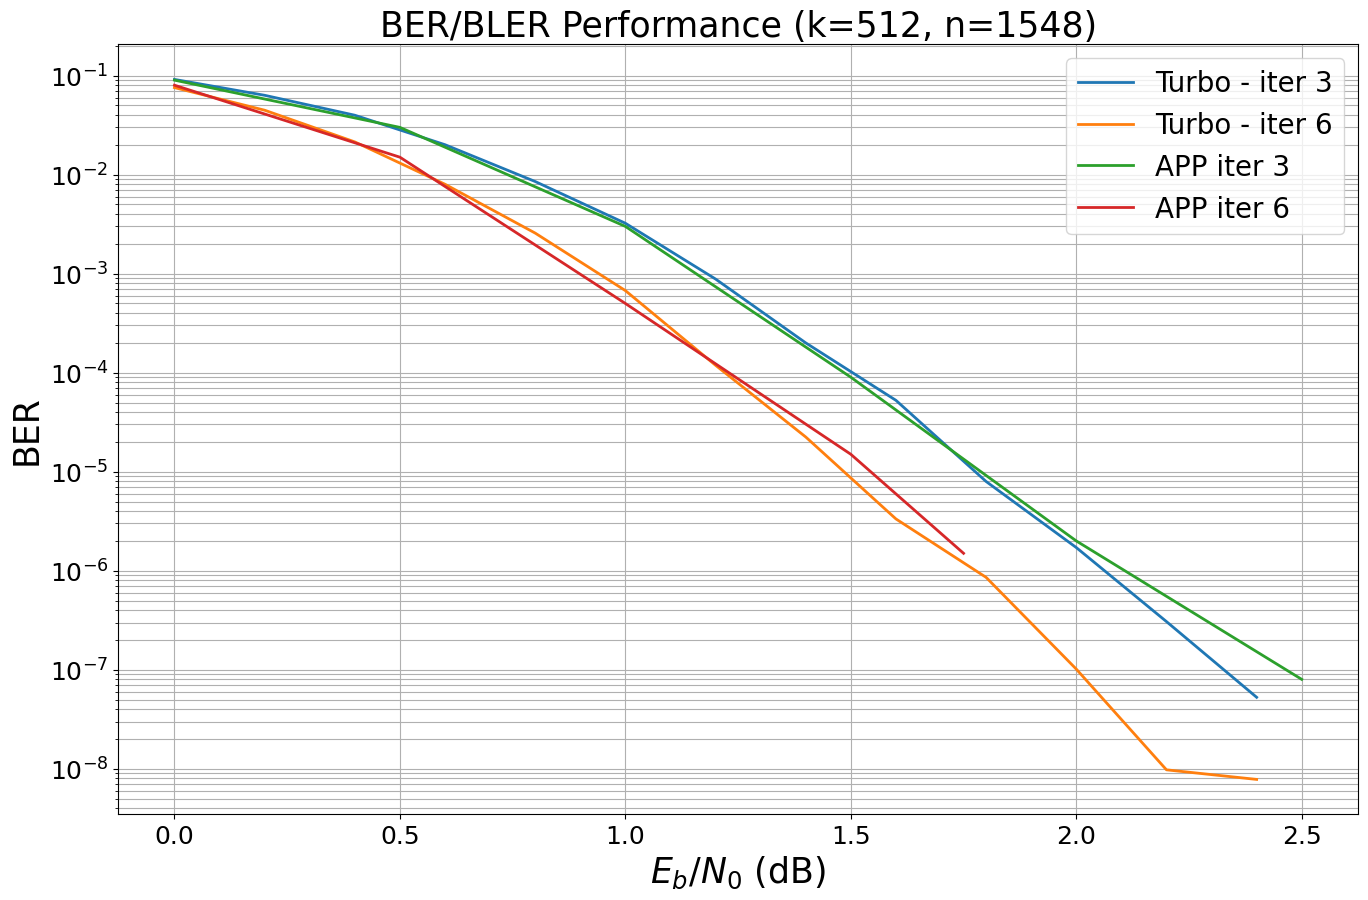

In [23]:
# and show the figure
ber_plot1(show_bler=False) 

## Test Against Aff3ct

We test against the aff3ct BER performance.

### Aff3ct k=2048/n=4108

In [7]:
# code parameters
k = 2048 # number of information bits per codeword
n = 4104 # desired codeword length
num_bits_per_symbol = 2 # QPSK
ebno_db = np.arange(0, 2, 0.2) # sim SNR range 

codes_under_test = []
#Turbo. codes
enc = TurboEncoder(rate=1/2, constraint_length=4, terminate=True)
dec = TurboDecoder(encoder=enc, num_iter=8)
name = "Turbo - constraint_length " + str(enc.constraint_length)
codes_under_test.append([enc, dec, name])

ber_plot2 = PlotBER(f"BER/BLER Performance (k={k}, n={n})")

# run ber simulations for each code we have added to the list
for code in codes_under_test:
    print("\n Running: " + code[2])
    
    # generate a new model with the given encoder/decoder
    model = System_Model(k=k,
                         n=n,
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=code[0],
                         decoder=code[1],
                         sim_esno=False)
    
    # the first argument must be a callable (function) that yields u and u_hat for batch_size and ebno
    ber_plot2.simulate(model, # the function have defined previously
                     ebno_dbs=ebno_db, # SNR to simulate
                     legend=code[2], # legend string for plotting
                     max_mc_iter=100, # run 100 Monte Carlo runs per SNR point
                     num_target_bit_errors=1000, # continue with next SNR point after 1000 bit errors
                     batch_size=10000, # batch-size per Monte Carlo run
                     soft_estimates=False, # the model returns hard-estimates
                     early_stop=True, # stop simulation if no error has been detected at current SNR point
                     show_fig=False, # we show the figure after all results are simulated
                     add_bler=True, # in case BLER is also interresting
                     forward_keyboard_interrupt=False); # should be True in a loop

#Aff3ct results
#https://aff3ct.github.io/comparator.html?curve0=773c4e0&xaxis=Eb%2FN0&yaxes=BER%2CFER&xrange=-0.026776519052523172,1.973223480947477&yrange=-9.17124842407813,0.1896539704466922

snr = [0, 0.5, 1, 1.5, 2]
ber = [1.67e-01, 1.26e-01, 1.81e-02, 1.43e-05, 3.76e-09]
bler = [1., 1., 3.16e-01, 6.88e-04, 2.21e-06]

ber_plot2.add(snr, ber, is_bler=False,legend="Aff3ct")
ber_plot2.add(snr, bler, is_bler=True,legend="Aff3ct")




 Running: Turbo - constraint_length 4
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.2567e-01 | 1.0000e+00 |     2573813 |    20480000 |        10000 |       10000 |        21.5 |reached target bit errors
      0.2 | 1.0983e-01 | 9.9980e-01 |     2249286 |    20480000 |         9998 |       10000 |         2.2 |reached target bit errors
      0.4 | 8.7681e-02 | 9.8080e-01 |     1795705 |    20480000 |         9808 |       10000 |         2.2 |reached target bit errors
      0.6 | 5.4484e-02 | 8.3300e-01 |     1115839 |    20480000 |         8330 |       10000 |         2.2 |reached target bit errors
      0.8 | 1.9562e-02 | 4.3350e-01 |      400624 |    20480000 |         4335 |       10000 |         2.2 |reached target bit errors
      1.0 | 3.4308e-03 | 1.0740e-01 

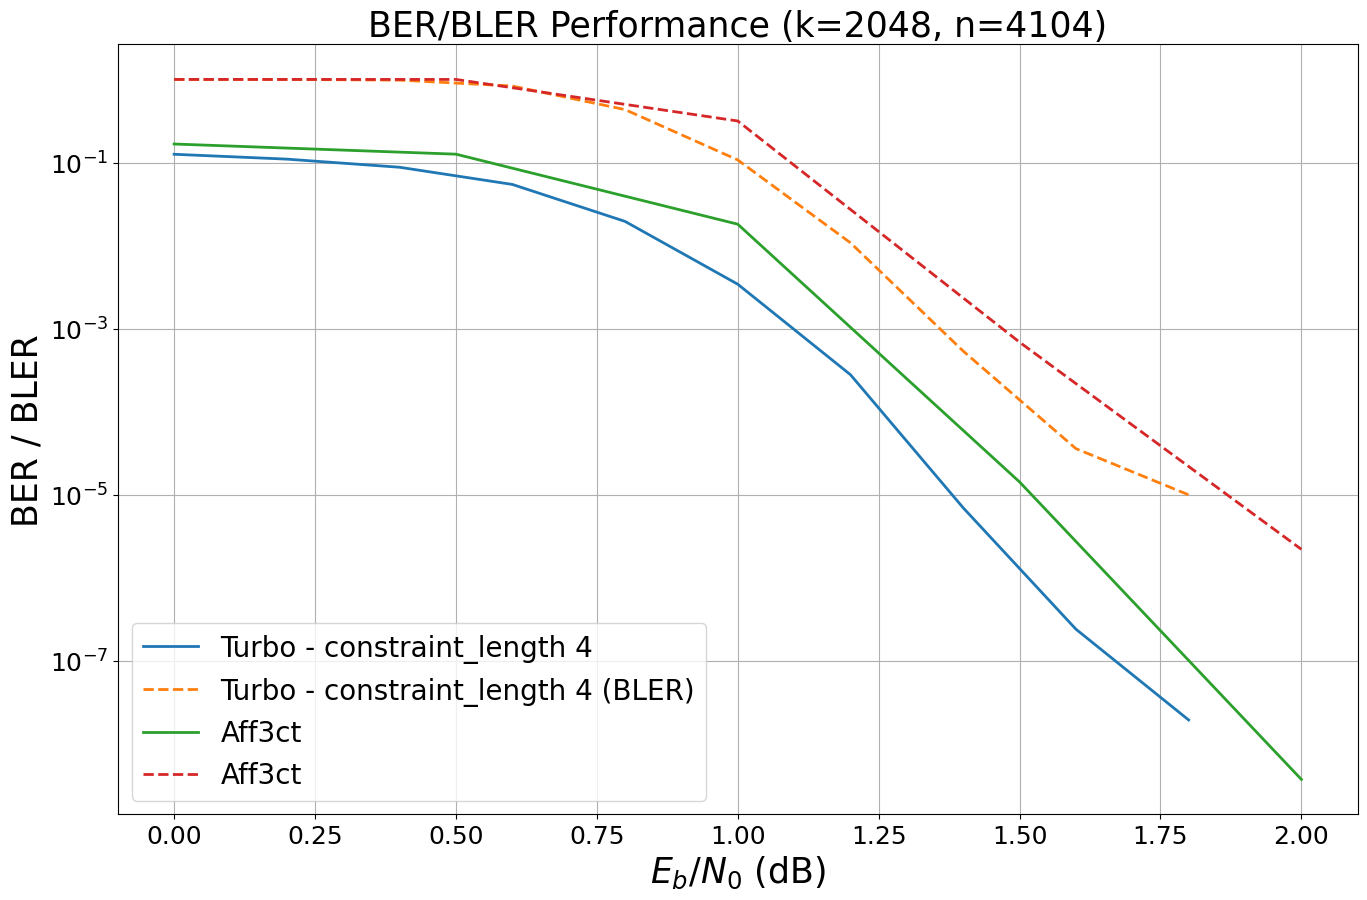

In [8]:
# and show the figure
ber_plot2() 

### Aff3ct k=6144/n=18444

In [9]:
# code parameters
k = 6144 # number of information bits per codeword
n = 18444 # desired codeword length
num_bits_per_symbol = 2 # QPSK
ebno_db = np.arange(0, 1, 0.2) # sim SNR range 

codes_under_test = []
#Turbo. codes
enc = TurboEncoder(rate=1/3, constraint_length=4, terminate=True)
dec = TurboDecoder(encoder=enc, num_iter=6)
name = "Turbo - constraint_length " + str(enc.constraint_length)
codes_under_test.append([enc, dec, name])

ber_plot3 = PlotBER(f"BER/BLER Performance (k={k}, n={n})")

# run ber simulations for each code we have added to the list
for code in codes_under_test:
    print("\n Running: " + code[2])
    
    # generate a new model with the given encoder/decoder
    model = System_Model(k=k,
                         n=n,
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=code[0],
                         decoder=code[1],
                         sim_esno=False)
    
    # the first argument must be a callable (function) that yields u and u_hat for batch_size and ebno
    ber_plot3.simulate(model, # the function have defined previously
                     ebno_dbs=ebno_db, # SNR to simulate
                     legend=code[2], # legend string for plotting
                     max_mc_iter=100, # run 100 Monte Carlo runs per SNR point
                     num_target_bit_errors=1000, # continue with next SNR point after 1000 bit errors
                     batch_size=10000, # batch-size per Monte Carlo run
                     soft_estimates=False, # the model returns hard-estimates
                     early_stop=True, # stop simulation if no error has been detected at current SNR point
                     show_fig=False, # we show the figure after all results are simulated
                     add_bler=True, # in case BLER is also interresting
                     forward_keyboard_interrupt=False); # should be True in a loop

#Aff3ct results
#https://aff3ct.github.io/comparator.html?curve0=773c4e0&curve1=a3ee4f2&xaxis=Eb%2FN0&yaxes=BER%2CFER&xrange=-0.026776519052523172,1.973223480947477&yrange=-9.17124842407813,0.1896539704466922

snr = [0, 0.5, 1]
ber = [1.37e-01, 1.31e-03, 1.30e-08]
bler = [1., 2.21e-01, 3.26e-05]

ber_plot3.add(snr, ber, is_bler=False,legend="Aff3ct")
ber_plot3.add(snr, bler, is_bler=True,legend="Aff3ct")



 Running: Turbo - constraint_length 4
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 6.6043e-02 | 9.9770e-01 |     4057654 |    61440000 |         9977 |       10000 |        78.0 |reached target bit errors
      0.2 | 1.5885e-02 | 8.0270e-01 |      975990 |    61440000 |         8027 |       10000 |         5.1 |reached target bit errors
      0.4 | 6.0164e-04 | 1.4260e-01 |       36965 |    61440000 |         1426 |       10000 |         5.1 |reached target bit errors
      0.6 | 2.5321e-06 | 2.8857e-03 |        1089 |   430080000 |          202 |       70000 |        35.5 |reached target bit errors
      0.8 | 2.4902e-08 | 5.7000e-05 |         153 |  6144000000 |           57 |     1000000 |       506.8 |reached max iter       


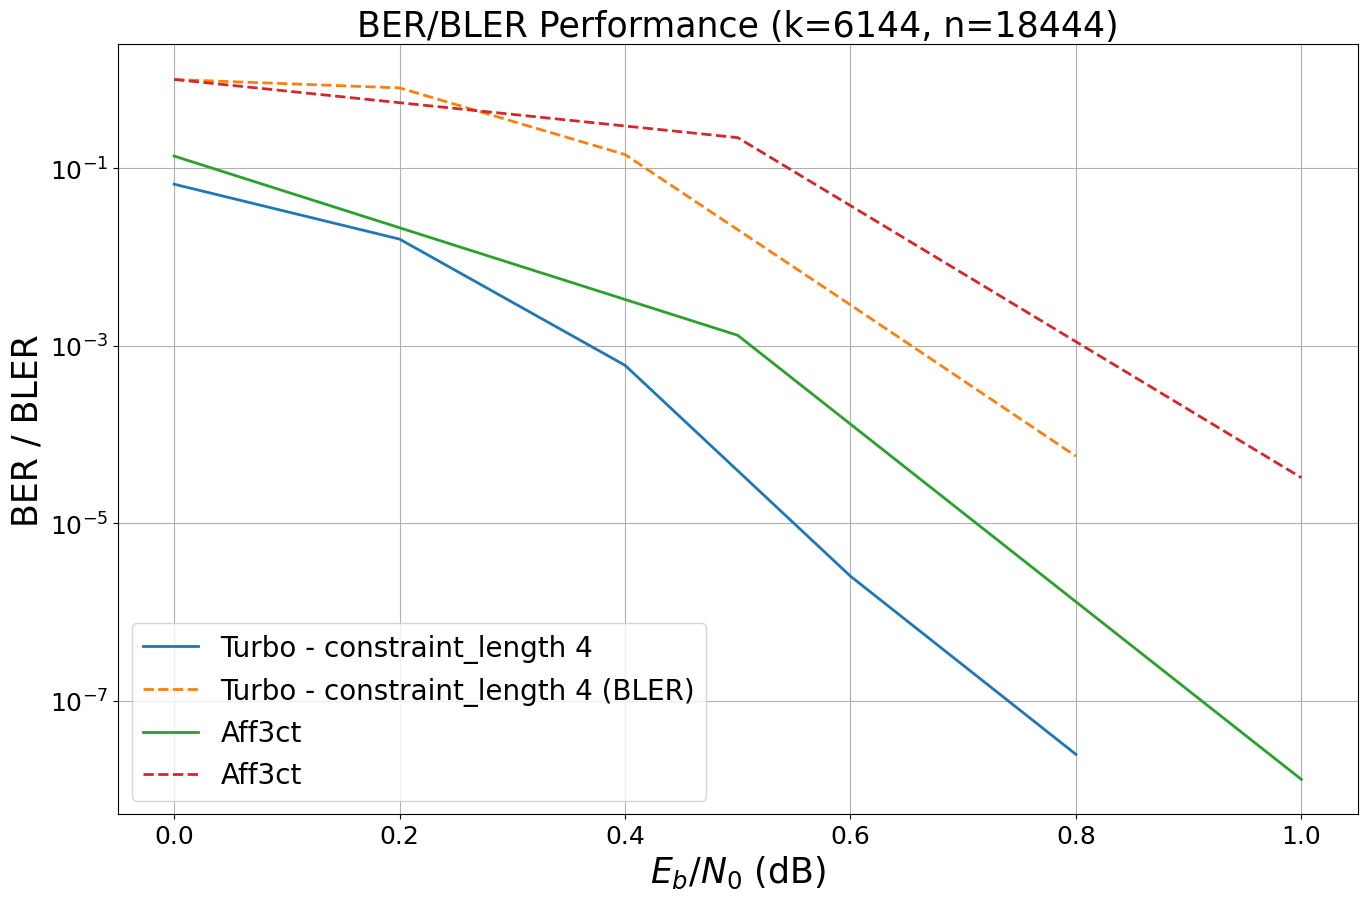

In [10]:
# and show the figure
ber_plot3() 

## Test Polynomials & Constraint Length

Basic idea: the BLER performance should improve monotonically with increasing constraint length

### Convolutional code rate=1/2

In [11]:
# code parameters
k = 500 # number of information bits per codeword
n = 1000 # desired codeword length

num_bits_per_symbol = 2 # QPSK
ebno_db = np.arange(0, 8, 0.5) # sim SNR range 

codes_under_test = []
# Conv. code with Viterbi decoding
for c in range(3,9):
    enc = ConvEncoder(rate=1/2, constraint_length=c)
    dec = ViterbiDecoder(gen_poly=enc.gen_poly)
    name = f"Conv. Code Viterbi (constraint length {c})"
    codes_under_test.append([enc, dec, name])

ber_plot4 = PlotBER(f"BER/BLER Performance (k={k}, n={n})")

# run ber simulations for each code we have added to the list
for code in codes_under_test:
    print("\n Running: " + code[2])
    
    # generate a new model with the given encoder/decoder
    model = System_Model(k=k,
                         n=n,
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=code[0],
                         decoder=code[1],
                         sim_esno=False)
    
    # the first argument must be a callable (function) that yields u and u_hat for batch_size and ebno
    ber_plot4.simulate(model, # the function have defined previously
                     ebno_dbs=ebno_db, # SNR to simulate
                     legend=code[2], # legend string for plotting
                     max_mc_iter=100, # run 100 Monte Carlo runs per SNR point
                     num_target_bit_errors=1000, # continue with next SNR point after 1000 bit errors
                     batch_size=10000, # batch-size per Monte Carlo run
                     soft_estimates=False, # the model returns hard-estimates
                     early_stop=True, # stop simulation if no error has been detected at current SNR point
                     show_fig=False, # we show the figure after all results are simulated
                     add_bler=True, # in case BLER is also interresting
                     forward_keyboard_interrupt=False); # should be True in a loop




 Running: Conv. Code Viterbi (constraint length 3)
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 9.2903e-02 | 1.0000e+00 |      464514 |     5000000 |        10000 |       10000 |         2.9 |reached target bit errors
      0.5 | 6.4554e-02 | 1.0000e+00 |      322771 |     5000000 |        10000 |       10000 |         0.0 |reached target bit errors
      1.0 | 4.2025e-02 | 9.9920e-01 |      210127 |     5000000 |         9992 |       10000 |         0.0 |reached target bit errors
      1.5 | 2.5959e-02 | 9.8650e-01 |      129796 |     5000000 |         9865 |       10000 |         0.0 |reached target bit errors
      2.0 | 1.4656e-02 | 9.2520e-01 |       73279 |     5000000 |         9252 |       10000 |         0.0 |reached target bit errors
      2.5 | 7.6192e-03 

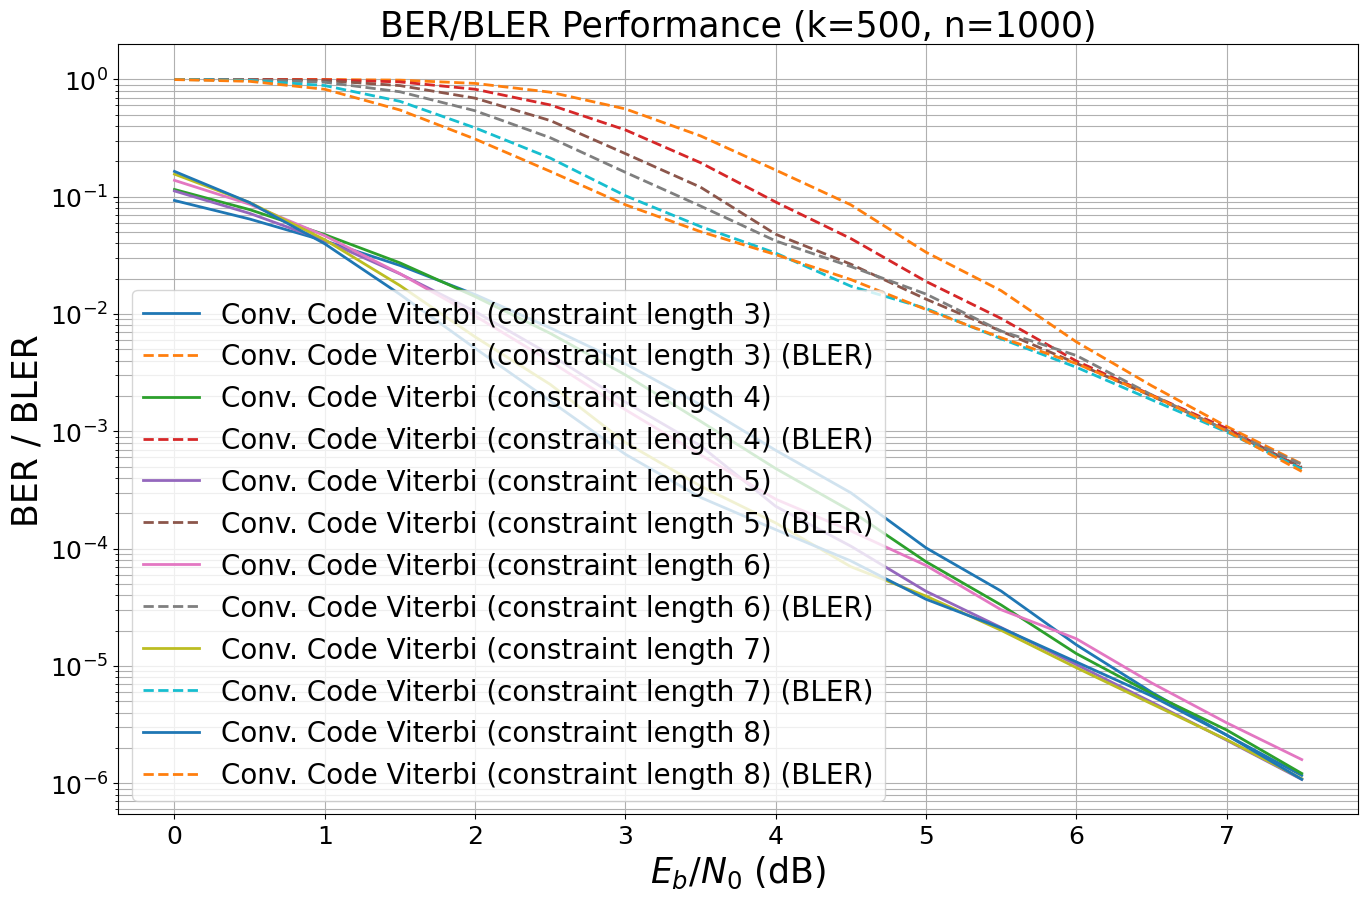

In [12]:
# and show the figure
ber_plot4() 

### Convolutional code rate=1/3

In [13]:
# code parameters
k = 500 # number of information bits per codeword
n = 1500 # desired codeword length
num_bits_per_symbol = 2 # QPSK
ebno_db = np.arange(0, 8, 0.5) # sim SNR range 

codes_under_test = []
# Conv. code with Viterbi decoding
for c in range(3,9):
    enc = ConvEncoder(rate=1/3, constraint_length=c)
    dec = ViterbiDecoder(gen_poly=enc.gen_poly)
    name = f"Conv. Code Viterbi (constraint length {c})"
    codes_under_test.append([enc, dec, name])

ber_plot5 = PlotBER(f"BER/BLER Performance (k={k}, n={n})")

# run ber simulations for each code we have added to the list
for code in codes_under_test:
    print("\n Running: " + code[2])
    
    # generate a new model with the given encoder/decoder
    model = System_Model(k=k,
                         n=n,
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=code[0],
                         decoder=code[1],
                         sim_esno=False)
    
    # the first argument must be a callable (function) that yields u and u_hat for batch_size and ebno
    ber_plot5.simulate(model, # the function have defined previously
                     ebno_dbs=ebno_db, # SNR to simulate
                     legend=code[2], # legend string for plotting
                     max_mc_iter=100, # run 100 Monte Carlo runs per SNR point
                     num_target_bit_errors=1000, # continue with next SNR point after 1000 bit errors
                     batch_size=10000, # batch-size per Monte Carlo run
                     soft_estimates=False, # the model returns hard-estimates
                     early_stop=True, # stop simulation if no error has been detected at current SNR point
                     show_fig=False, # we show the figure after all results are simulated
                     add_bler=True, # in case BLER is also interresting
                     forward_keyboard_interrupt=False); # should be True in a loop


 Running: Conv. Code Viterbi (constraint length 3)
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.0794e-01 | 1.0000e+00 |      539701 |     5000000 |        10000 |       10000 |         2.2 |reached target bit errors
      0.5 | 7.6775e-02 | 9.9990e-01 |      383875 |     5000000 |         9999 |       10000 |         0.1 |reached target bit errors
      1.0 | 5.1282e-02 | 9.9900e-01 |      256409 |     5000000 |         9990 |       10000 |         0.1 |reached target bit errors
      1.5 | 3.2026e-02 | 9.8880e-01 |      160131 |     5000000 |         9888 |       10000 |         0.1 |reached target bit errors
      2.0 | 1.8175e-02 | 9.3890e-01 |       90874 |     5000000 |         9389 |       10000 |         0.0 |reached target bit errors
      2.5 | 9.6616e-03 

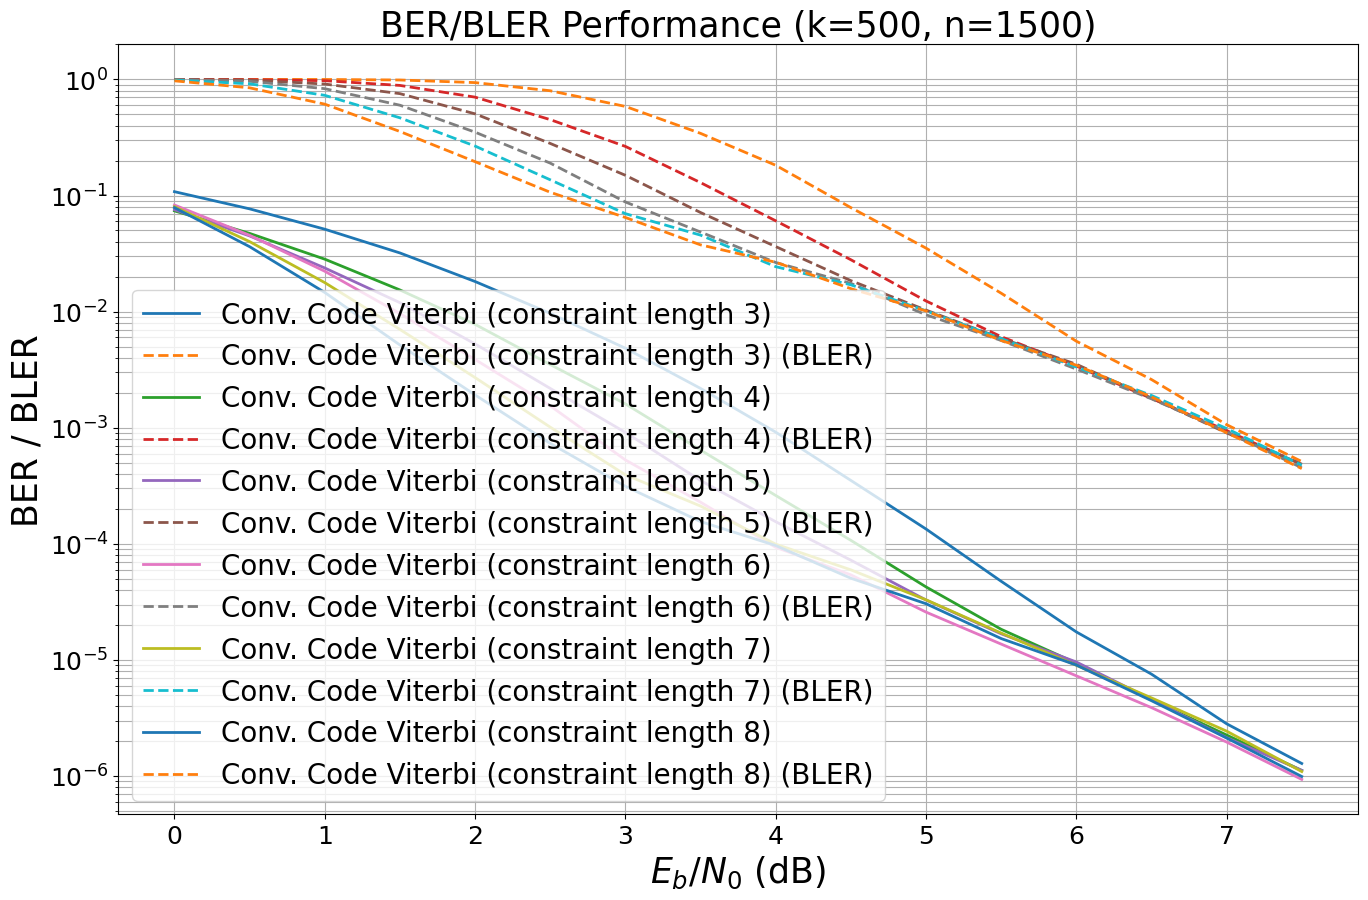

In [14]:
# and show the figure
ber_plot5() 

### Turbo code rate=1/2

In [ ]:
# code parameters
k = 500 # number of information bits per codeword
n = 1000 # desired codeword length
num_bits_per_symbol = 2 # QPSK
ebno_db = np.arange(0, 8, 0.5) # sim SNR range 

codes_under_test = []
# Turbo Codes
for c in range(3,7):
    enc = TurboEncoder(rate=1/2, constraint_length=c, terminate=False)
    dec = TurboDecoder(encoder=enc, num_iter=6)
    name = "Turbo - constraint_length " + str(enc.constraint_length)
    codes_under_test.append([enc, dec, name])

ber_plot6 = PlotBER(f"BER/BLER Performance (k={k}, n={n})")

# run ber simulations for each code we have added to the list
for code in codes_under_test:
    print("\n Running: " + code[2])
    
    # generate a new model with the given encoder/decoder
    model = System_Model(k=k,
                         n=n,
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=code[0],
                         decoder=code[1],
                         sim_esno=False)
    
    # the first argument must be a callable (function) that yields u and u_hat for batch_size and ebno
    ber_plot6.simulate(model, # the function have defined previously
                     ebno_dbs=ebno_db, # SNR to simulate
                     legend=code[2], # legend string for plotting
                     max_mc_iter=100, # run 100 Monte Carlo runs per SNR point
                     num_target_bit_errors=1000, # continue with next SNR point after 1000 bit errors
                     batch_size=10000, # batch-size per Monte Carlo run
                     soft_estimates=False, # the model returns hard-estimates
                     early_stop=True, # stop simulation if no error has been detected at current SNR point
                     show_fig=False, # we show the figure after all results are simulated
                     add_bler=True, # in case BLER is also interresting
                     forward_keyboard_interrupt=False); # should be True in a loop





 Running: Turbo - constraint_length 3
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.0784e-01 | 9.9540e-01 |      539182 |     5000000 |         9954 |       10000 |         7.4 |reached target bit errors
      0.5 | 6.0897e-02 | 8.8090e-01 |      304486 |     5000000 |         8809 |       10000 |         0.3 |reached target bit errors
      1.0 | 1.8416e-02 | 4.5460e-01 |       92078 |     5000000 |         4546 |       10000 |         0.3 |reached target bit errors
      1.5 | 2.5820e-03 | 1.0590e-01 |       12910 |     5000000 |         1059 |       10000 |         0.3 |reached target bit errors
      2.0 | 1.7720e-04 | 1.5450e-02 |        1772 |    10000000 |          309 |       20000 |         0.6 |reached target bit errors
      2.5 | 3.3467e-05 | 3.8167e-03 

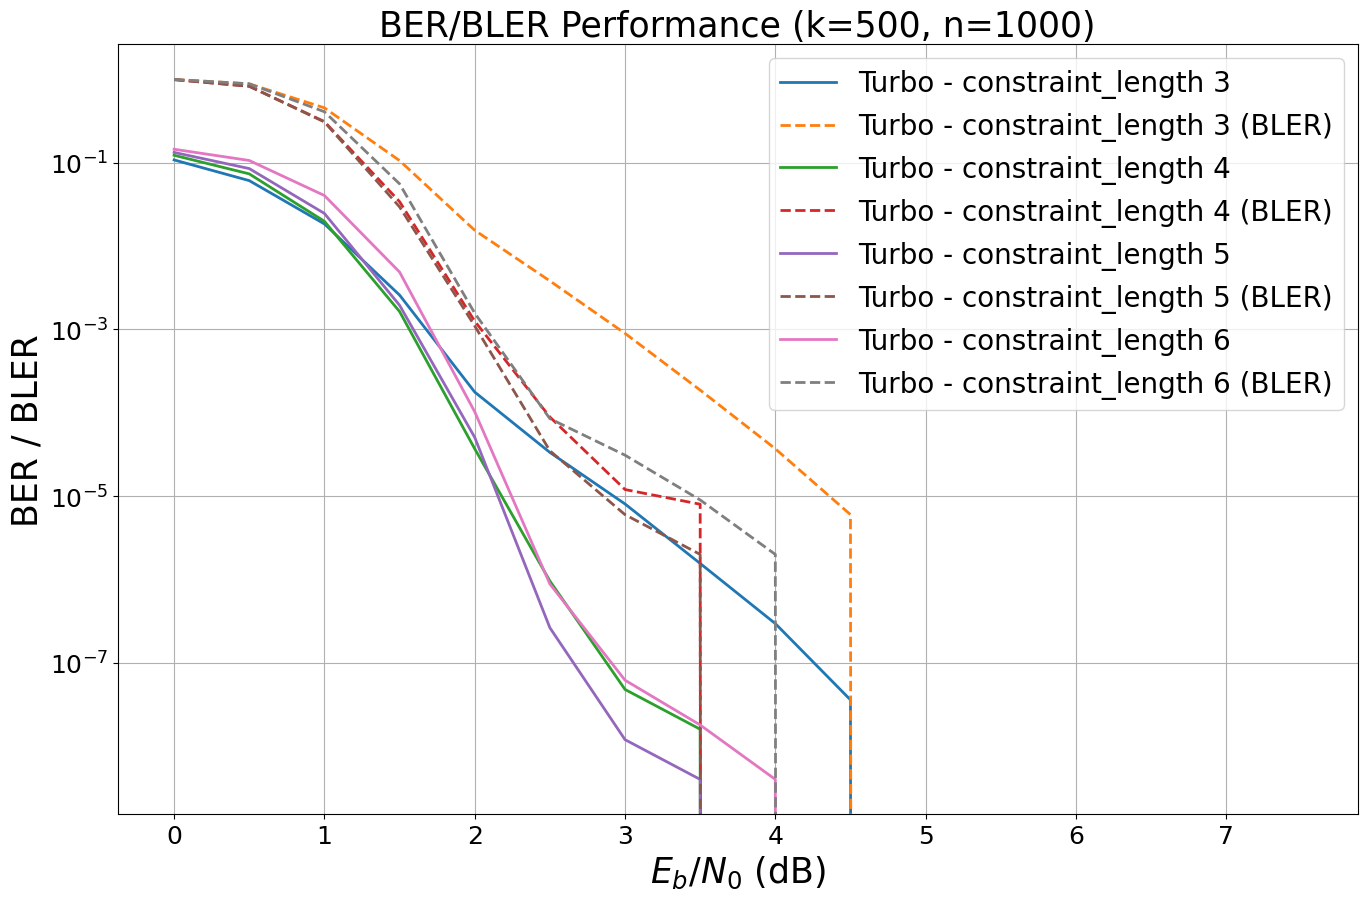

In [20]:
# and show the figure
ber_plot6() 

### Turbo code rate=1/3

In [ ]:
# code parameters
k = 500 # number of information bits per codeword
n = 1500 # desired codeword length
num_bits_per_symbol = 2 # QPSK
ebno_db = np.arange(0, 8, 0.5) # sim SNR range 

codes_under_test = []
# Turbo Codes
for c in range(3,7):
    enc = TurboEncoder(rate=1/3, constraint_length=c, terminate=False)
    dec = TurboDecoder(encoder=enc, num_iter=6)
    name = "Turbo - constraint_length " + str(enc.constraint_length)
    codes_under_test.append([enc, dec, name])

ber_plot7 = PlotBER(f"BER/BLER Performance (k={k}, n={n})")

# run ber simulations for each code we have added to the list
for code in codes_under_test:
    print("\n Running: " + code[2])
    
    # generate a new model with the given encoder/decoder
    model = System_Model(k=k,
                         n=n,
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=code[0],
                         decoder=code[1],
                         sim_esno=False)
    
    # the first argument must be a callable (function) that yields u and u_hat for batch_size and ebno
    ber_plot7.simulate(model, # the function have defined previously
                     ebno_dbs=ebno_db, # SNR to simulate
                     legend=code[2], # legend string for plotting
                     max_mc_iter=100, # run 100 Monte Carlo runs per SNR point
                     num_target_bit_errors=1000, # continue with next SNR point after 1000 bit errors
                     batch_size=10000, # batch-size per Monte Carlo run
                     soft_estimates=False, # the model returns hard-estimates
                     early_stop=True, # stop simulation if no error has been detected at current SNR point
                     show_fig=False, # we show the figure after all results are simulated
                     add_bler=True, # in case BLER is also interresting
                     forward_keyboard_interrupt=False); # should be True in a loop




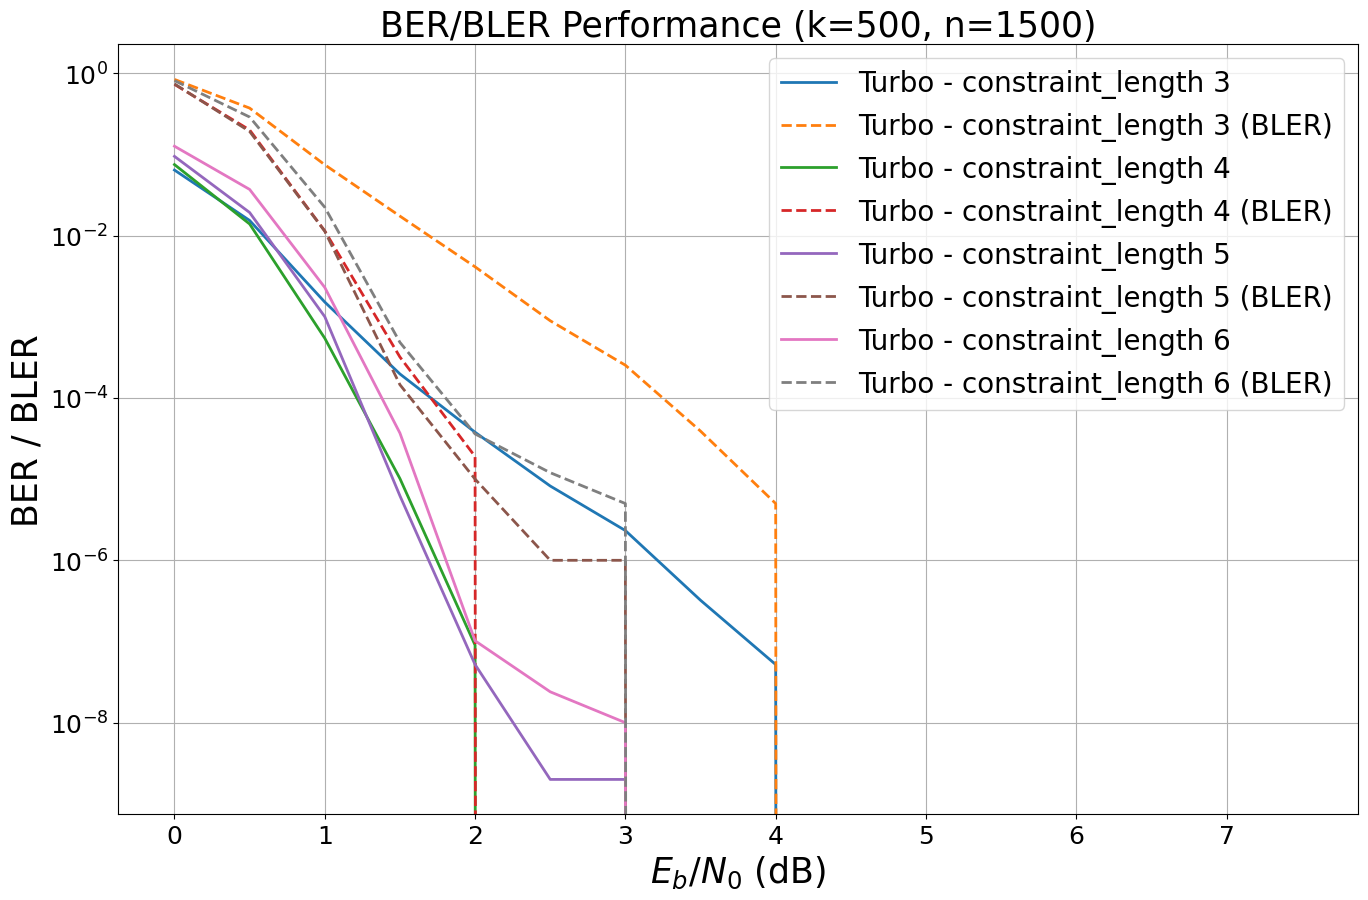

In [21]:
# and show the figure
ber_plot7() 